In [1]:
import nbsetup
import ergodicpy as ep
import numpy as np
import seaborn as sns
import scipy as sp
import pandas as pd
from simulations.snowflake.models import Snowflake, SnowVerse
import matplotlib.pyplot as plt
import copy

In [536]:
def generate(total_steps, history_steps, states, variant_ensembles, trials):    
    # run trials
    flakes = []
    for t in range(trials):
        nbsetup.cp(t)
        sv = SnowVerse(history_steps=history_steps, future_steps=total_steps-history_steps, states=states, variants=variant_ensembles)
        flakes.append(sv)
    
    return flakes

METHODS = ('current', 'frequentist', 'bayes', '1/js', '1/kl','alt/kl','alt bayes')

kl_div = sp.stats.entropy
js_div = sp.spatial.distance.jensenshannon

def analyse(reference, flakes, method=0):
    data = []
    for i, sv in enumerate(flakes):
        current_hist = sv.primer.histogram(sv.states) # sv.current_pmf
        future_pmf = sv.future_pmf # sv.ec().ergodic_pmf()
        
        rec = reference.ec#(states=sv.states, at_point=sv.steps)
        
        if method == 0:
            predicted_pmf = current_hist
        elif method == 1:
            predicted_pmf = rec.ergodic_pmf()
        elif method == 2:
            posterior = bayesian(rec.weights, rec.histograms, current_hist)
            if np.sum(posterior) == 0:
                predicted_pmf = current_hist/current_hist.sum()
            else:
                predicted_pmf = ep.point_pmf(rec.histograms, posterior)
        elif method == 3:
            posterior = [js_div(current_hist, h)**-1 for h in rec.histograms]
            predicted_pmf = ep.point_pmf(rec.histograms, posterior)
        elif method == 4:
            posterior = [kl_div(current_hist, h)**-1 for h in rec.histograms]
            if np.sum(posterior) == 0:
                predicted_pmf = current_hist/current_hist.sum()
            else:
                predicted_pmf = ep.point_pmf(rec.histograms, posterior)
        
        kl_avgs, js_avgs = [], []
        for variant in sv.variants:
            individual = variant.histogram()#states=sv.states, at_point=sv.steps)
            kl_avgs.append(kl_div(predicted_pmf, individual))
            js_avgs.append(js_div(predicted_pmf, individual))
        
        data.append({
            'sv_complexity': sv.ec.complexity,
            'rf_complexity': rec.complexity,
            'kl_div': kl_div(predicted_pmf, future_pmf),
            'kl_avg': np.mean(kl_avgs),
            'js_div': js_div(predicted_pmf, future_pmf),
            'js_avg': np.mean(js_avgs),
            'history_steps': sv.history_steps,
            'future_steps': sv.future_steps,
            'method': METHODS[method],
            'trial': i,
        })
    return data

In [533]:
def meta_analyse(reference, flurry, x='history_steps'):
    data = []
    for key, flakes in flurry.items():
        nbsetup.cp(key)
        for i in range(len(METHODS)):
            data += analyse(reference, flakes, method=i)
    df = pd.DataFrame(data=data)
    meta_plot(df, x)
    return df

def meta_plot(df, x, y='js'):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15,5))
    g = sns.lineplot(data=df, x=x, y='sv_complexity', ax=axes[0])
    g.set(title='Ergodic complexity of SnowVerse')
    
    g = sns.lineplot(data=df, x=x, y='%s_div' % y, hue='method', ax=axes[1])
    g.set(title='DJS of combined variant distribution')
    
    g = sns.lineplot(data=df, x=x, y='%s_avg' % y, hue='method', ax=axes[2])
    g.set(title='Avg(DJS) for each variant')

In [528]:
def np_norm(arr):
    arr = np.array(arr)
    ars = arr.sum()
    if ars == 0:
        return np.zeros(len(arr))
    return arr/ars

def rn(hists):
    """ Row normalize """
    hists = np.array(hists)
    return (hists/hists.sum(axis=1)[:, np.newaxis])

def bayesian(prior, likelihood_functions, observations):
    prior = np_norm(prior)
    likelihood_functions = rn(likelihood_functions)
    for i, n in enumerate(observations):
        for _ in range(n):
            prior = np_norm(prior*np.array([l[i] for l in likelihood_functions]))
    return prior

def bayesian_norm(prior, likelihood_functions, observations):
    prior = np_norm(prior)    
    observations = np_norm(observations)
    likelihood = np.array([np.product((l/np.sum(l))**observations) for l in likelihood_functions])
    return prior*likelihood


Setting up the reference snowflakes to compare against for all experiments from here on, using many in this instance to reduce variability.

In [245]:
total_steps = 600
states = 360
reference = SnowVerse(variants=1000, history_steps=0, future_steps=total_steps, states=states)

## Adjusting steps backwards

As in less of a shared history over the same total distance

In [520]:
flurry = {}
for hs in [20,100,200,300,400,550]:
    flakes = generate(history_steps=hs, variant_ensembles=20, trials=20, total_steps=total_steps, states=states)
    flurry[hs] = flakes

19


550


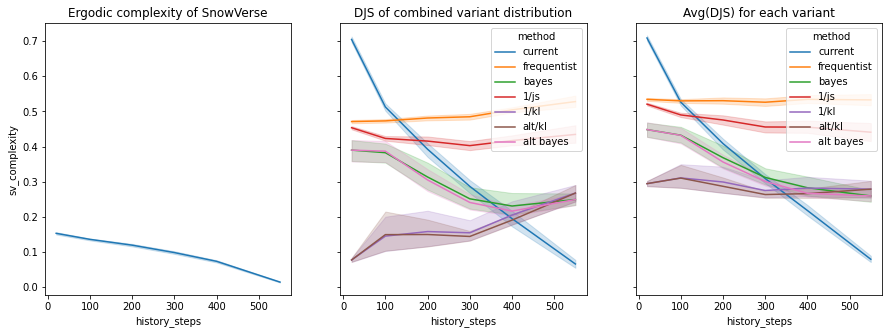

In [537]:
back_results = meta_analyse(reference, flurry)

550


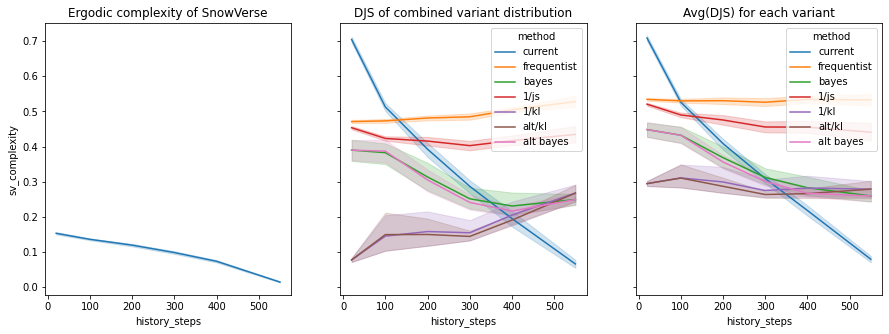

In [540]:
back_results = meta_analyse(reference, flurry)

[(0.0, 0.5893644757139589)]

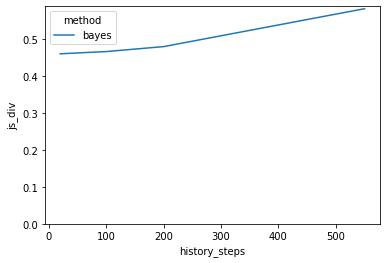

In [401]:
g = sns.lineplot(data=back_results[back_results['method'] == 'bayes'], y='js_div', x='history_steps', hue='method')
g.set(ylim=(0,None))

550


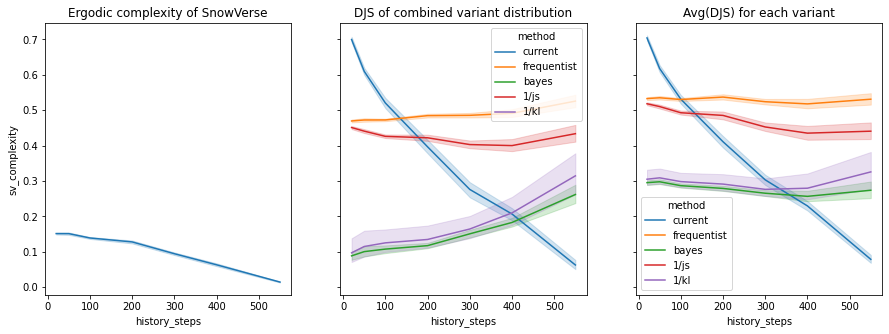

In [255]:
back_results = meta_analyse(reference, flurry)

- The more future steps, the less shared history (in this instance as total steps is kept constant), so the more room for the variants to diverge, this increasing ergodic complexity.
- The more future steps, the more the current distribution (i.e. the distribution at time of split), diverges from the average of the variants.
- However, this means, the more broad the distribution becomes, getting closer to the frequentist (ergodic) ensemble.
- But it should be noted, that when comparing the ergodic distribution (frequentist) against any one particular variant, it remains a consistent high amount, due to the ergodic complexity affects.
- While the Bayesian technique works incredibly effectively and consistently when comparing against the combined variant distribution.
- But, struggles with increasing future steps to predict the specific distribution of each specific variant, as this system has a low ergodic self organisation.

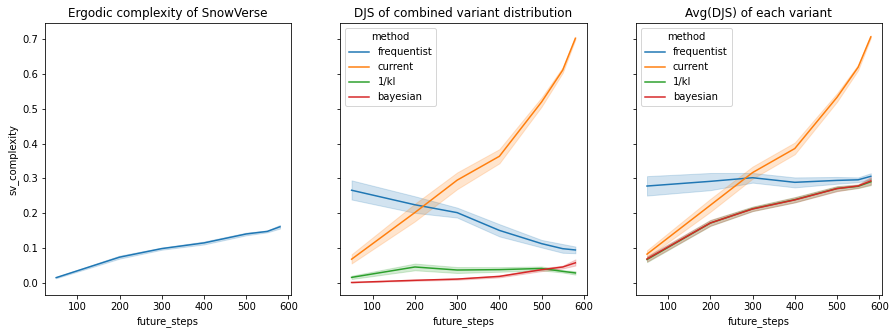

In [210]:
meta_plot(back_results, 'future_steps')

## Adjusting steps forward

As in the same length of shared history, but moving further into the future

In [247]:
flurry_distance = {}
for ds in [20,100,300]:
    flakes = generate(history_steps=300, variant_ensembles=20, trials=20, total_steps=300+ds, states=states)
    flurry_distance[ds] = flakes

19


300


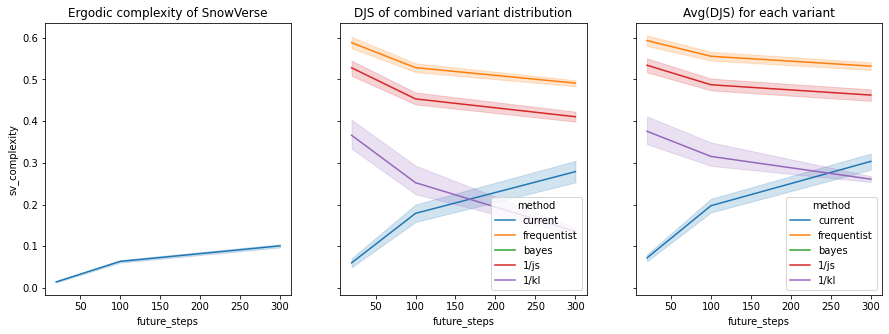

In [250]:
dist_results = meta_analyse(reference, flurry_distance, 'future_steps')

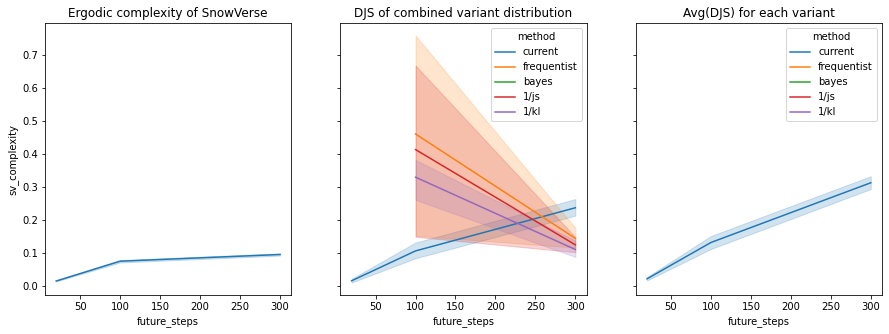

In [244]:
meta_plot(dist_results, 'future_steps', 'kl')

- The more steps you take into the future, the more it diverges from the current shared history, therefore the higher the ergodic complexity.
- The further into the future it goes, the more each variant diverges from each other, the more spread they become, so the closer they get to ther ergodic ensemble and the frequentist interpretation works.
- However, conversely, because this has low ergodic self organisation, the further into the future it becomes the more different each variant becomes. The bayesian predicted pmf when comparing against the average distribution across all variants, stays remarkably accurate (& by far the best predicting mechanism).
- However, when comparing it's effeciency against individual variant distributions, the further out you get the worse it becomes (since it has low ergodic self organisation, so naturally there would be a higher degree of uncertainty).

In [298]:
likely = [[0.1,0.8],[0.5,0.5],[1.0,0.0],[0.0,1.0]]
prior = [1,1,1,1]
post1 = bayesian(prior, likely, [1,0])
post1

array([0.0625, 0.3125, 0.625 , 0.    ])

In [299]:
post2 = bayesian(post1, likely, [1,0])
post2

array([0.00793651, 0.1984127 , 0.79365079, 0.        ])

In [300]:
post_1 = bayesian(prior, likely, [2,0])
post_1

array([0.00793651, 0.1984127 , 0.79365079, 0.        ])

In [307]:
likelyb = [[0.1,0.9],[0.9,0.1]]

In [308]:
test_2 = bayesian([1,1], likelyb, [1,0])
test_2

array([0.1, 0.9])

In [309]:
test_23 = bayesian(test_2, likelyb, [1,0])
test_23

array([0.01219512, 0.98780488])

In [310]:
bayesian([1,1], [[0.1,0.9],[0.9,0.1]], [2,0])

array([0.01219512, 0.98780488])